# Jarvis March In Python
## Housekeeping
Run these few cells of code to set things up for future bits of code.

In [1]:
import numpy as np
import pandas as pd
import plotnine
import csv
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_path

## Motivation
Say we have a set of points, whether it be data points or just randomly generated, and we want to be able to find the minimum amount of points such that if we were to connect the points by lines, all other points would be contatined in the boundry. The premise of this is quite simple, but how would we code this? and how would we do it for random structures like this?

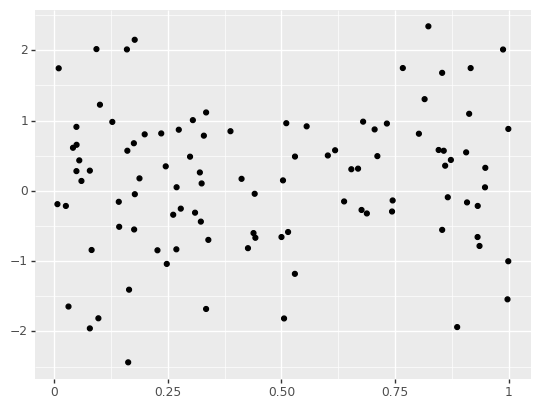

In [3]:
points=[]
for i in range(100):
    points.append((np.random.uniform(0,1,1),np.random.normal(0,1,1)))

X=[]
Y=[]
for pt in points:
    X.append(float(pt[0]))
    Y.append(float(pt[1]))
df = pd.DataFrame({"X" : X,"Y" : Y})
p = ggplot(df,aes(x=X,y=Y)) + geom_point()
print(p)

One way we could do this is by using the Jarvis March (gift wrapping) algoritm. Below is the psuedo code provided:

S is a set of points in a plane, p,q and r are in S.

1. Initialise p as leftmost point.
2. Do following while we do not come back to the first (or leftmost) point.

    a. The next point q is the point such that the triplet (p, q, r) is counterclockwise for any other point r.
    
    b. next[p] = q (Store q as next of p in the output convex hull).
    
    c. p = q (Set p as q for next iteration).

### (Side note/confession)
There are 2 things I feel the need to mention/comment upon. Firstly, this code is quite ambiguous, not telling us specifically what we want to be done in order to find for something to be seen as counterclockwise. The premise of a triplet being counterclockwise of other triplets is somewhat confusing. After a talk with fellow students over lunch, we found that all 3 involved in the conversation had coded the algorithm different ways, yet all from the same pseudo code - this goes to show the level of ambiguity. However, I think that my code may be the most different and probably not actually performing the correct algorithm (as we will see).

Secondly, I decided I wanted to try coding this myself so didn't look at any other code online thus not to be influeced by other's ideas. This leads to 2 issues; I may be unknowingly doing something that someone has already written, and it also leads to me making errors that I would have spotted when looking at someone elses code. The latter will be seen in my code where I have failed to spot that in the pseudo code it states "p,q and r are in S" - I have not used this fact, leading to my 'unique' (wrong) algorithm.

## Better Psuedo Code
In an attempt to reduce ambiguity, I will provide more clear psuedo code, which will be more closely related to what I have actually coded. I plan to include the relevant maths where needed. Some parts will obviously be similar as the end result shoudl be the same.

Input: $S$ - a set of points

1. Initialise `L` as leftmost point, and `R` as rightmost point. Set `p = L`.


2. While `p` $\neq$ `R`:

    a. Create temporary point `true_north` directly 1 unit above `p`.
    
    b. For each point, `q` $\in S$, calculate the angle `true_north,p,q`:
    
    $ \theta = \cos^{-1} \left( \frac{n \cdot m}{|n||m|}\right), $
    
    where $n, m$ are treated as vectors and $n = $ `true_north` - `p`, and $m = $`q` - `p`.
    
    c. Choose `q` such that $ q = \text{minarg } \theta$, append `q` to `Convex Hull` and update `p = q`.
    
    
3. While `p` $\neq$ `L`:

    a. Create temporary point `true_south` directly 1 unit below `p`.
    
    b. For each point, `q` $\in S$, calculate the angle `true_south,p,q`:
    
    $ \theta = \cos^{-1} \left( \frac{n \cdot m}{|n||m|}\right), $
    
    where $n, m$ are treated as vectors and $n = $ `true_south` - `p`, and $m = $`q` - `p`.
    
    c. Choose `q` such that $ q = \text{minarg } \theta$, append `q` to `Convex Hull` and update `p = q`.
    

4. Return `Convex Hull`

### Comparisons

I like to think my code makes the algorithm a lot less ambiguous, which is probably the main pro. My code also has a little more mathematical grounding, and expressly tells the user how to workout key values, and how we chosse points.

However the main downside of my pseudo code is the addition of dummy points. While this is useful for my algorithm, it is not what is intended in the original proposition of the algorithm. Adding dummy points also mean not everything is based purely with what is given to us, i.e. we are using made up points, not the points that are inputted as data. 

My code also includes a lot more 'checks' of the set compared to the original provided psuedo code. That is, due to the nature of angles, we are required to know where the rightmost point is so that we can 'flip' the algorithm upside down so that the minimum angled point is always the next one in the convex hull.

## Code
### Point Class
In order to make the future algorithm easier to run, we create a class structure for points, with a few helpful member functions that will help in the end. Points will take the form $(x,y)$.

In [4]:
class point :
    x = None
    y = None
    
    def add(a,b) :
        c = point()
        c.x = a.x + b.x
        c.y = a.y + b.y
        return  c
    
    def subtract(a,b) :
        c = point()
        c.x = a.x - b.x
        c.y = a.y - b.y
        return c
    
    def __init__(self,x = 0.0,y = 0.0) :
        self.x = x
        self.y = y
        
    def print(self) :
        print("(",self.x,",",self.y,")")
        
    def dist(a,b) :
        #Euclidean distance: a^2 + b^2 = c^2
        dsq = (a.x-b.x)**2 + (a.y-b.y)**2
        return dsq**(1/2)
    
    def dot(a,b) :
        #Dot product, treating points as vectors (mathematically)
        d = a.x*b.x + a.y*b.y
        return d
    
    def angle(a,b,c,forJM = False) :
        #Find interior angle using dot product formula
        
        #Find magnitude of points as if vectors coming from b as respective origin
        mag_ab = point.dist(a,b)
        mag_bc = point.dist(b,c)
        
        #Find dot product of ba and bc
        a_as_vec = point.subtract(a,b)
        c_as_vec = point.subtract(b,c)
        
        dot_ab_bc = point.dot(a_as_vec,c_as_vec)
        
        #Find angle
        ang = np.arccos(dot_ab_bc/(mag_ab * mag_bc))
        
        #For the use of Jarvis March Alg., find exterior angle if c is to the left of a 
        if forJM == True:
            if c.x < a.x:
                ang = 2*np.pi - ang
        return ang

To begin the class we have some generic and useful member functions such as add, subtract, intitalise and print. These are self explanatory and are generally useful to have for either point manipulation/making or just allowing us to make sanity checks.

The last three are a bit more mathematical. The `dist` member function allows us to find the Euclidean distance between 2 points using Pythagorus' theorem, `dot` simply finds the dot product between 2 points. The `angle` function then finds the angle formed from intersecting line segments with common point `b` extending out to points `a` and `c` using the formula stated in the psuedo code above. (Finds the interior angle of point triplet `a,b,c`.)

The `forJM` part of our last member funciton, just allows us to find the exterior angle if `c` is to the left of `a`. Which is useful for the way my code is written, and makes sure we are measuring the minimum angle as the first clockwise point starting at "12 o'clock". If this isn't used then it would see a point which is closer to "12 o'clock" but in the wrong direction as the minimum. (i.e. would make us move left instead of right when we know the left move would be in the boundry of our already made convex hull.)

### Other Classes

When I first began tackling this assessment, I followed on from the course notes exercises, so originaly went into this with more class structures. Along side the `point` class, I also had a `line` class and a `line_segment` class, the latter being defined as a`line` and 2 `points`. 

While mathematically this makes sense, as it allows angles between segments to make more easily visualised, I found it made my code messy and all useful member functions could be easily translated into the `point` class instead. Wrapping all member functions needed for the Jarvis March algorithm in the `point` class was a lot neater and easier to use/comprehend.

### Jarvis March Python Code

In [5]:
def Jarvis_March(set_of_points, For_Plot = False) :
    #Initialisations
    S=set_of_points
    
    forleftmost=[]
    
    #find the left most point to start the algorithm
    for pt in S:
        forleftmost.append(float(pt.x))
    place = forleftmost.index(min(forleftmost))
    start = S[place]
    
    #set up our set of points for convex hull
    #if we want to plot the path of the hull we need the starting point at the start and end of our list so add it now
    if For_Plot == True:
        convex_hull=[start]
    else:
        convex_hull=[]
    
    #using our leftmost information, find the rightmost point
    rightmost = forleftmost.index(max(forleftmost))
    Right = S[rightmost]
    
    #set up a point which is exactly vertical of our current point
    true_north = point.add(start,point(0,1))
    
    #find angles between our current point and all others
    angles=[]
    S.remove(start) #Remove start from S as to not divide by 0
    for pt in S:
        ang = point.angle(true_north,start,pt,True)
        angles.append(ang)
        
    #append the smallest angles point to our convex hull 
    #as if angle is min then must be anti-clockwise of all other possible points
    angplace = angles.index(min(angles))
    newp = S[angplace]
    
    S.append(start) #add start back into S
    convex_hull.append(newp)
    
    while newp.x != Right.x or newp.y != Right.y:
        
        #While current point isn't the rightmost find the next minimum angled clockwise point
        #(measuring from 12 o'clock)
        
        S.remove(newp) # removing convex hull points from S cuts down on computational time ever so slightly
        true_north = point.add(newp,point(0,1))
        angles=[]
        for pt in S :
            ang = point.angle(true_north, newp, pt,True)
            angles.append(ang)
        angplace = angles.index(min(angles))
        newp = S[angplace]
        convex_hull.append(newp)
    
    while newp.x != start.x or newp.y != start.y:
        
        #While current point isn't the starting point find the next minimum angled clockwise point
        #(measuring from 6 o'clock)
        
        S.remove(newp)
        true_south = point.subtract(newp,point(0,1))
        angles=[]
        for pt in S :
            ang = point.angle(pt, newp, true_south,True)
            angles.append(ang)
        angplace = angles.index(min(angles))
        newp = S[angplace]
        convex_hull.append(newp)
    
    #Once we return to the start point return the convex hull as a list of points
    return convex_hull

Note that we have a `For_Plot` `True`/`False` input. This is purely to allow the starting point to be at both ends of our list of points which allows a path to be plotted which fully encloses all points. However this does increase the hull size by 1 repeated point. So if set to `False`, the algorithm will just give the minimal amount of points.

Now that we have our code, lets see how it does against another random example and see if it can find the convex hull.

( [0.02592457] , [-0.36621329] )
( [0.03868101] , [-0.8345262] )
( [0.05523981] , [-1.05847685] )
( [0.52338516] , [-1.6213768] )
( [0.88249703] , [-1.89320414] )
( [0.92285377] , [-1.54509374] )
( [0.98994892] , [-0.85763949] )
( [0.99159325] , [-0.22911338] )
( [0.98601769] , [0.98539876] )
( [0.96098141] , [1.26776012] )
( [0.65436304] , [2.73881778] )
( [0.064506] , [1.86107203] )
( [0.02649642] , [0.82530378] )


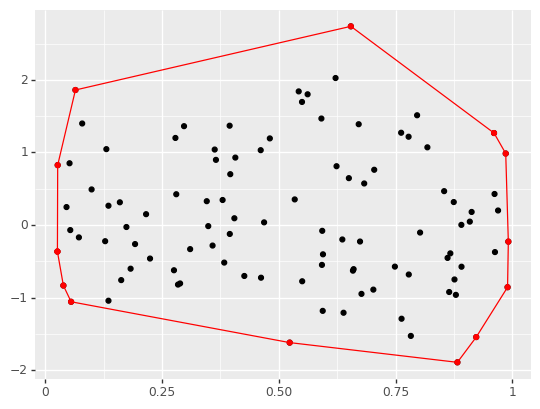

In [6]:
points=[]
for i in range(100):
    points.append(point(np.random.uniform(0,1,1),np.random.normal(0,1,1)))

X=[]
Y=[]
for pt in points:
    X.append(float(pt.x))
    Y.append(float(pt.y))
df = pd.DataFrame({"X" : X,"Y" : Y})
p = ggplot(df,aes(x=X,y=Y)) + geom_point()

Hull = Jarvis_March(points,True)
for pt in Hull[:len(Hull)-1]:
    point.print(pt)

hullX=[]
hullY=[]
for pt in Hull:
    hullX.append(float(pt.x))
    hullY.append(float(pt.y))
df2 = pd.DataFrame({"X" : hullX,"Y" : hullY})
p2 = ggplot(df2,aes(x=hullX,y=hullY)) + geom_point()
ptest = p + geom_point(df2,aes(x=hullX,y=hullY),color="red") + geom_path(df2,aes(x=hullX,y=hullY),color="red")
print(ptest)

## Data Sets

The following examples are provided as part of the assessment as to check how the algorithm works against a few constructed data sets. Here are the results:

### Line

( 1.0 , 1.0 )
( 2.0 , 2.0 )
( 3.0 , 3.0 )


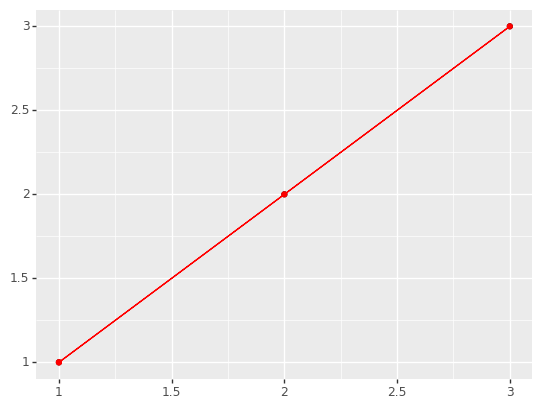

In [13]:
# open the file
with open('line.csv',mode='r') as csv_file :
    # create a reader - this allows a delimiter to be specified and used
    csv_reader = csv.reader(csv_file, delimiter=',')
    # do not know how many rows - so initialise some empty lists
    C1 = []
    C2 = []
    # read each row of the file ...
    for row in csv_reader :
        # .. and put the data into the lists
        C1.append(row[0])
        C2.append(row[1])
line=[]
for i in range(len(C1)):
    line.append(point(float(C1[i]),float(C2[i])))
X=[]
Y=[]
for pt in line:
    X.append(float(pt.x))
    Y.append(float(pt.y))
df = pd.DataFrame({"X" : X,"Y" : Y})
p = ggplot(df,aes(x=X,y=Y)) + geom_point()

Hull_line = Jarvis_March(line,True)
for pt in Hull_line[:len(Hull_line)-1]:
    point.print(pt)

hullX=[]
hullY=[]
for pt in Hull_line:
    hullX.append(float(pt.x))
    hullY.append(float(pt.y))
df2 = pd.DataFrame({"X" : hullX,"Y" : hullY})
p2 = ggplot(df2,aes(x=hullX,y=hullY)) + geom_point()
ptest = p + geom_point(df2,aes(x=hullX,y=hullY),color="red") + geom_path(df2,aes(x=hullX,y=hullY),color="red")
print(ptest)

### Pgram

( 1 , 1 )
( 2 , 1 )
( 3 , 2 )
( 2.5 , 2.5 )
( 2 , 2 )


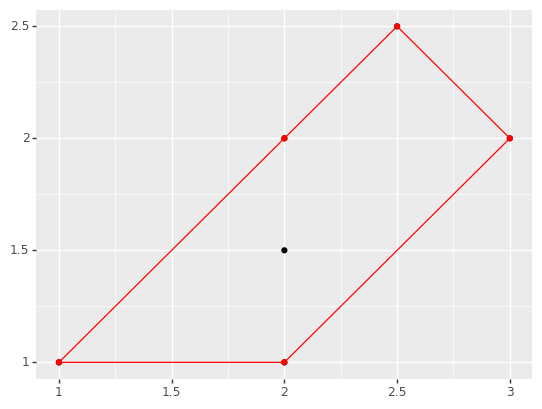

In [8]:
#The pgram file wasn't loading correctly due to added empty lines at the bottom of the csv
#instead I have written them out incase your pgram file also doesnt load
pgram=[point(1,1),point(2,1),point(3,2),point(2,2), point(2.0,1.5),point(2.5,2.5)]
X=[]
Y=[]
for pt in pgram:
    X.append(float(pt.x))
    Y.append(float(pt.y))
df = pd.DataFrame({"X" : X,"Y" : Y})
p = ggplot(df,aes(x=X,y=Y)) + geom_point()

Hull_pgram = Jarvis_March(pgram,True)
for pt in Hull_pgram[:len(Hull_pgram)-1]:
    point.print(pt)

hullX=[]
hullY=[]
for pt in Hull_pgram:
    hullX.append(float(pt.x))
    hullY.append(float(pt.y))
df2 = pd.DataFrame({"X" : hullX,"Y" : hullY})
p2 = ggplot(df2,aes(x=hullX,y=hullY)) + geom_point()
ptest = p + geom_point(df2,aes(x=hullX,y=hullY),color="red") + geom_path(df2,aes(x=hullX,y=hullY),color="red")
print(ptest)

### Square

( 1.0 , 1.0 )
( 2.0 , 1.0 )
( 2.0 , 2.0 )
( 1.5 , 2.5 )
( 1.0 , 2.0 )


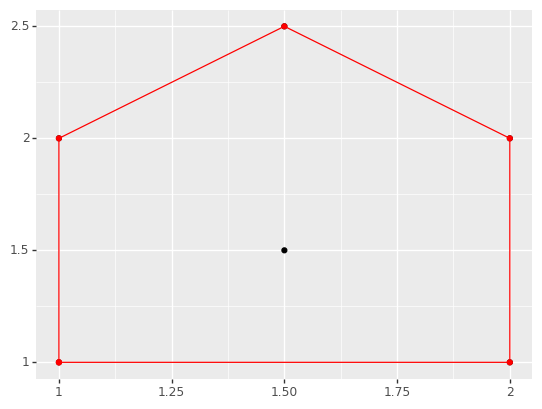

In [9]:
# open the file
with open('square.csv',mode='r') as csv_file :
    # create a reader - this allows a delimiter to be specified and used
    csv_reader = csv.reader(csv_file, delimiter=',')
    # do not know how many rows - so initialise some empty lists
    C1 = []
    C2 = []
    # read each row of the file ...
    for row in csv_reader :
        # .. and put the data into the lists
        C1.append(row[0])
        C2.append(row[1])
sq=[]
for i in range(len(C1)):
    sq.append(point(float(C1[i]),float(C2[i])))
X=[]
Y=[]
for pt in sq:
    X.append(float(pt.x))
    Y.append(float(pt.y))
df = pd.DataFrame({"X" : X,"Y" : Y})
p = ggplot(df,aes(x=X,y=Y)) + geom_point()

Hull_sq = Jarvis_March(sq,True)
for pt in Hull_sq[:len(Hull_sq)-1]:
    point.print(pt)

hullX=[]
hullY=[]
for pt in Hull_sq:
    hullX.append(float(pt.x))
    hullY.append(float(pt.y))
df2 = pd.DataFrame({"X" : hullX,"Y" : hullY})
p2 = ggplot(df2,aes(x=hullX,y=hullY)) + geom_point()
ptest = p + geom_point(df2,aes(x=hullX,y=hullY),color="red") + geom_path(df2,aes(x=hullX,y=hullY),color="red")
print(ptest)

### Random

( -0.71657388106957 , 1.20219702232312 )
( -0.605200231305254 , 0.957134110706781 )
( -0.432249029757549 , 0.600185398765638 )
( 0.156196864138666 , 0.537196258340319 )
( 0.353922330922547 , 0.654945271536898 )
( 0.505823570824408 , 1.12001307650065 )
( 0.358984412999769 , 1.56677311480003 )
( -0.380951747864001 , 1.45310545712829 )
( -0.545292317957066 , 1.4050365090573 )


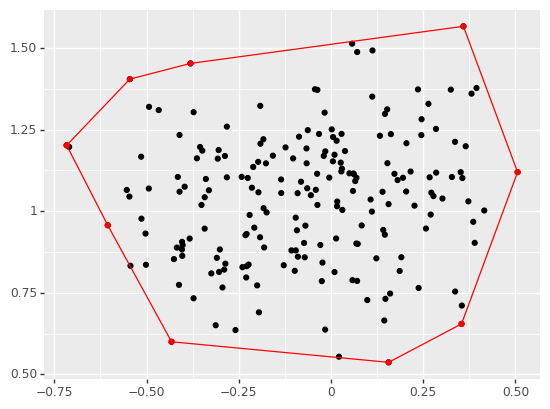

In [10]:
# open the file
with open('random.csv',mode='r') as csv_file :
    # create a reader - this allows a delimiter to be specified and used
    csv_reader = csv.reader(csv_file, delimiter=',')
    # do not know how many rows - so initialise some empty lists
    C1 = []
    C2 = []
    # read each row of the file ...
    for row in csv_reader :
        # .. and put the data into the lists
        C1.append(row[0])
        C2.append(row[1])
rand=[]
for i in range(len(C1)):
    rand.append(point(float(C1[i]),float(C2[i])))
X=[]
Y=[]
for pt in rand:
    X.append(float(pt.x))
    Y.append(float(pt.y))
df = pd.DataFrame({"X" : X,"Y" : Y})
p = ggplot(df,aes(x=X,y=Y)) + geom_point()

Hull_rand = Jarvis_March(rand,True)
for pt in Hull_rand[:len(Hull_rand)-1]:
    point.print(pt)

hullX=[]
hullY=[]
for pt in Hull_rand:
    hullX.append(float(pt.x))
    hullY.append(float(pt.y))
df2 = pd.DataFrame({"X" : hullX,"Y" : hullY})
p2 = ggplot(df2,aes(x=hullX,y=hullY)) + geom_point()
ptest = p + geom_point(df2,aes(x=hullX,y=hullY),color="red")+ geom_path(df2,aes(x=hullX,y=hullY),color="red")
print(ptest)

## Testing
### Computational Time

One important factor that may wish to be known, is how long it takes for the algorithm to run. Or more importantly how long will the computational time scale as more points are added.

If done correctly the Jarvis march algorithm has $O(nh)$. As our code runs, at a particular poit, we check the angle between every other point. We do this and then add in another point into our hull once all points have been checked. This is then repeated for the next point in our hull. Following this line of thought, this means we check all $n$ points, for every point in our hull $h$. Hence, our order should be $O(nh)$. But let's check this.

(Note that we have ever so slightly cut down on computatioal time by removing points from our set if they are in our hull, which means we actually take less than $n$ checks for each of our hull points.)

The following code allows us to plot running time of our algorithm with random data sets. The code has been modified from a coursework about the Travelling Salesman Problem ran by Jamie Fairbrother, hence why `matplotlib` has been used instead of `ggplot`.

In [14]:
n_trials = 100 #number of problems to solve for each problem size
n_list = [50,100,150,200,250,300,350,400,450,500,1000] #number of random points in each set of points

average_time_norm=[]
average_time_uni=[]
average_time_mix=[]

for n in n_list:
    dur_norm=[]
    dur_uni=[]
    dur_mix=[]
    
    for i in range(n_trials):
        points_norm=[]
        points_uni=[]
        points_mix=[]
        for i in range(n):
            points_norm.append(point(np.random.normal(0,1,1),np.random.normal(0,1,1)))
            points_uni.append(point(np.random.uniform(0,1,1),np.random.uniform(0,1,1)))
            points_mix.append(point(np.random.normal(0,1,1),np.random.uniform(0,1,1)))
        
        tic_norm = time.perf_counter()
        Jarvis_March(points_norm)
        toc_norm = time.perf_counter()
        
        dur_n = toc_norm - tic_norm
        dur_norm.append(dur_n)
        
        tic_uni = time.perf_counter()
        Jarvis_March(points_uni)
        toc_uni = time.perf_counter()
        
        dur_u = toc_uni - tic_uni
        dur_uni.append(dur_u)
        
        tic_mix = time.perf_counter()
        Jarvis_March(points_norm)
        toc_mix = time.perf_counter()
        
        dur_m = toc_mix - tic_mix
        dur_mix.append(dur_m)
        
        
    
    average_time_norm.append(np.mean(dur_norm))
    average_time_uni.append(np.mean(dur_uni))
    average_time_mix.append(np.mean(dur_mix))

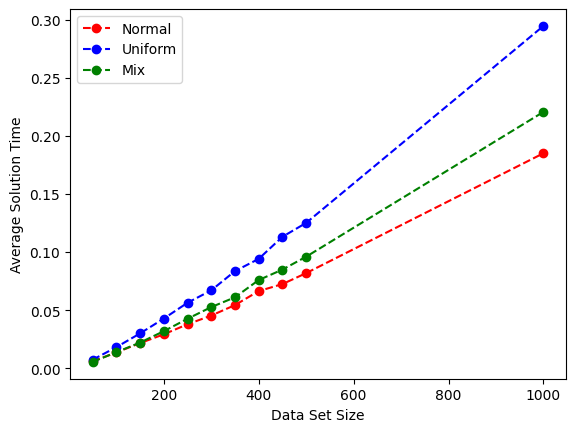

In [15]:
plt.plot(n_list,average_time_norm, '--o', color='r', label='Normal')
plt.plot(n_list,average_time_uni, '--o', color='b', label='Uniform')
plt.plot(n_list,average_time_mix, '--o', color='g', label='Mix')
plt.xlabel('Data Set Size')
plt.ylabel('Average Solution Time')
plt.legend()

I've decided to see how the algorithm works against different random distributions, one set where both $x$ and $y$ values come from a Normal distribution, one where they come from a Uniform distribution, and finally one where the $x$ value comes from a Normal distribution and $y$ values come from a Uniform distribution.

We can see that these lines look somewhere between linear and quadratic so $O(nh)$ seems reasonable. The worst case scenario would be if all data set points are on the hull, then we would have $O(n^2)$.

It is intresting to see that the distribution does seem to have an affect on how long the algorithm takes to run.

## Conclusion

After looking at Wikipedia and an animation of how Jarvis march algorithm works, I now see that my algorithm doesn't actually perform a Jarvis march but does find the convex hull in a some what niave way. However, it does seem to find a convex hull in all situations tested so I would say it seems like a success. The algorithm also scales with $O(nh)$, which is similar to that of the true Jarvis march algorithm.